In [1]:
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import os, sys

**Check if run on GPU**

In [2]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7970155775116730935, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3188244480
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15143224350285626252
 physical_device_desc: "device: 0, name: Quadro M2200, pci bus id: 0000:01:00.0, compute capability: 5.2"]

**Define some plotting function for Images Plotting**

In [21]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # make the minimum == 0, so the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")
    
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

## Variational AutoEncoder
<br> <br> The structure of Variational AutoEncoder
<img src="./images/vae_struc.jpg" alt="Drawing" style="width: 400px;"/>

According to the paper [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114) by Diederik P Kingma, Max Welling, (Prior Distribution == Multivariate Gaussian) after applying the **Reparameterize Trick**, the update equation should be <img src="./images/update_equ.jpg" alt="Drawing" style="width: 600px;"/>


<img src="./images/vae_update.jpg" alt="Drawing" style="width: 600px;"/>

### The following are 2 ways to construct the middle hidden layers:
1. Simply using Sigma: 

```python
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_sigma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_sigma), dtype=tf.float32)

hidden3 = hidden3_mean + hidden3_sigma * noise
```
   And the KL-Divergence Loss (latent loss) is: 
```python
eps = 1e-10 # smoothing term to avoid computing log(0) which is NaN
latent_loss = 0.5 * tf.reduce_sum(
    tf.square(hidden3_sigma) + tf.square(hidden3_mean)
    - 1 - tf.log(eps + tf.square(hidden3_sigma)))
```
<br>
2. Using Gamma = Log(Sigma ^ 2): <font color=red>Suggested, should use as default</font> 

  **Advantages**:
- Easier for th encoder to capture sigmas of diff scales (since it's in log_scale).
- Thus, speed up convergence.

```python
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_gamma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_gamma), dtype=tf.float32)

hidden3 = hidden3_mean + tf.exp(0.5 * hidden3_gamma) * noise
```
   And the KL-Divergence Loss (latent loss) is:
   
```python
latent_loss = 0.5 * tf.reduce_sum(
    tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)
```

### 1. Using Sigma (not seggested. slower to train than using Gamma)

In [28]:
tf.reset_default_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()

my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_sigma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_sigma), dtype=tf.float32)
hidden3 = hidden3_mean + hidden3_sigma * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)

update parameters

In [29]:
eps = 1e-10 # smoothing term to avoid computing log(0) which is NaN
latent_loss = 0.5 * tf.reduce_sum(
    tf.square(hidden3_sigma) + tf.square(hidden3_mean)
    - 1 - tf.log(eps + tf.square(hidden3_sigma)))

In [30]:
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [31]:
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)
        saver.save(sess, "./my_model_variational.ckpt")

0 Train total loss: 30892.982 	Reconstruction loss: 25192.078 	Latent loss: 5700.904
1 Train total loss: 26479.498 	Reconstruction loss: 22248.385 	Latent loss: 4231.114
2 Train total loss: 30246.613 	Reconstruction loss: 24441.742 	Latent loss: 5804.8716
39% Train total loss: 29246.807 	Reconstruction loss: 22198.572 	Latent loss: 7048.235
4 Train total loss: 23564.979 	Reconstruction loss: 19657.018 	Latent loss: 3907.961
5 Train total loss: 24407.871 	Reconstruction loss: 20368.953 	Latent loss: 4038.919
6 Train total loss: 20460.445 	Reconstruction loss: 17419.924 	Latent loss: 3040.5215
7 Train total loss: 18463.729 	Reconstruction loss: 15500.557 	Latent loss: 2963.1724
89% Train total loss: 17336.041 	Reconstruction loss: 14456.609 	Latent loss: 2879.431
9 Train total loss: 16678.086 	Reconstruction loss: 13551.635 	Latent loss: 3126.4502
10 Train total loss: 16924.59 	Reconstruction loss: 13807.882 	Latent loss: 3116.7075
11% Train total loss: 16049.297 	Reconstruction loss: 13

### 2. Using Gamma = Log(Sigma ^ 2): <font color=red>Suggested, should use as default</font>

   **Advantages**:
- Easier for th encoder to capture sigmas of diff scales (since it's in log_scale).
- Thus, speed up convergence.

```python
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_gamma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_gamma), dtype=tf.float32)

hidden3 = hidden3_mean + tf.exp(0.5 * hidden3_gamma) * noise
```
   And the KL-Divergence Loss (latent loss) is:
   
```python
latent_loss = 0.5 * tf.reduce_sum(
    tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)
```

In [32]:
tf.reset_default_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()
my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_gamma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_gamma), dtype=tf.float32)
hidden3 = hidden3_mean + tf.exp(0.5 * hidden3_gamma) * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)
latent_loss = 0.5 * tf.reduce_sum(
    tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

### Generate digits
VAE can easily generate NEW images after we got the optimal mu and var


In [34]:
n_digits = 60
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # not shown in the book
            sys.stdout.flush()                                          # not shown
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch}) # not shown
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)  # not shown
        saver.save(sess, "./my_model_variational.ckpt")  # not shown
    
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

0 Train total loss: 18309.676 	Reconstruction loss: 14652.379 	Latent loss: 3657.2974
1 Train total loss: 17665.941 	Reconstruction loss: 13812.877 	Latent loss: 3853.064
29% Train total loss: 15996.771 	Reconstruction loss: 12306.021 	Latent loss: 3690.7505
39% Train total loss: 16582.992 	Reconstruction loss: 12833.282 	Latent loss: 3749.7104
49% Train total loss: 16079.465 	Reconstruction loss: 12288.262 	Latent loss: 3791.203
59% Train total loss: 16266.664 	Reconstruction loss: 12427.944 	Latent loss: 3838.7195
69% Train total loss: 15541.54 	Reconstruction loss: 11795.1455 	Latent loss: 3746.3948
7 Train total loss: 15832.046 	Reconstruction loss: 12077.366 	Latent loss: 3754.6797
8 Train total loss: 15307.751 	Reconstruction loss: 11666.671 	Latent loss: 3641.08
9 Train total loss: 15874.557 	Reconstruction loss: 12106.566 	Latent loss: 3767.9905
10 Train total loss: 15287.209 	Reconstruction loss: 11538.771 	Latent loss: 3748.4377
11 Train total loss: 15596.767 	Reconstruction 

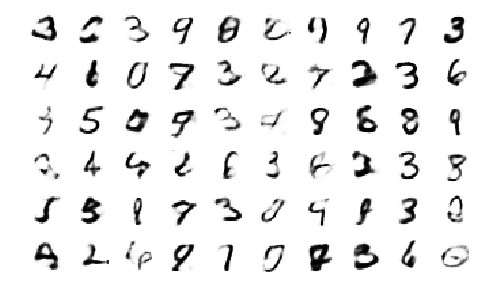

In [35]:
plt.figure(figsize=(8,50)) # not shown in the book
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])

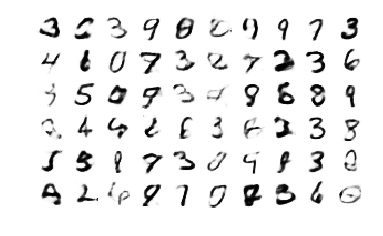

In [37]:
n_rows = 6
n_cols = 10
plot_multiple_images(outputs_val.reshape(-1, 28, 28), n_rows, n_cols)

plt.show()

In [38]:

latent_loss = 0.5 * tf.reduce_sum(
    tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)

## Encode & Decode

In [39]:
# Encode:
n_digits = 3
X_test, y_test = mnist.test.next_batch(batch_size)
codings = hidden3

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    codings_val = codings.eval(feed_dict={X: X_test})

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


In [40]:
# Decode:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    outputs_val = outputs.eval(feed_dict={codings: codings_val})

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


Plot the reconstructions:

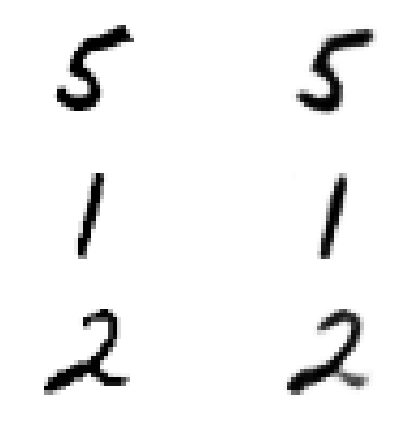

In [41]:
fig = plt.figure(figsize=(8, 2.5 * n_digits))
for iteration in range(n_digits):
    plt.subplot(n_digits, 2, 1 + 2 * iteration)
    plot_image(X_test[iteration])
    plt.subplot(n_digits, 2, 2 + 2 * iteration)
    plot_image(outputs_val[iteration])

### Interpolate digits

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


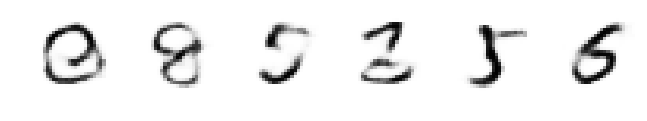

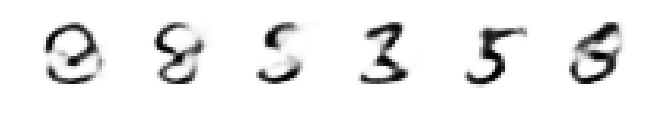

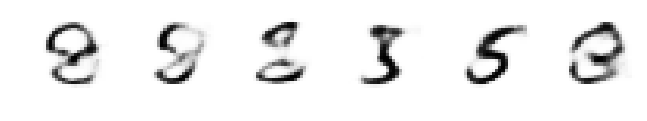

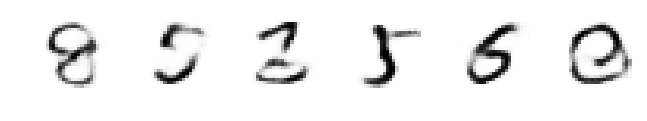

In [42]:
n_iterations = 3
n_digits = 6
codings_rnd = np.random.normal(size=[n_digits, n_hidden3])

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    target_codings = np.roll(codings_rnd, -1, axis=0)
    for iteration in range(n_iterations + 1):
        codings_interpolate = codings_rnd + (target_codings - codings_rnd) * iteration / n_iterations
        outputs_val = outputs.eval(feed_dict={codings: codings_interpolate})
        plt.figure(figsize=(11, 1.5*n_iterations))
        for digit_index in range(n_digits):
            plt.subplot(1, n_digits, digit_index + 1)
            plot_image(outputs_val[digit_index])
        plt.show()

In [4]:
# Try MNIST first
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/")

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## 1. Unsupervised Pretraining
AutoEncoder can extract representative features for high-dim inputs, serving as **intermediate level** for a Deep Neural Network.

```python
# The Weights and Biases we want to restore from the Pretrained-AutoEncoder
pretrain_saver = tf.train.Saver([weights1, weights2, biases1, biases2])
saver = tf.train.Saver()
```

Let's start by contructing a small neural network for MNIST classification:

In [5]:
tf.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_outputs = 10

learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.int32, shape=[None])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_outputs), name="biases3")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
logits = tf.matmul(hidden2, weights3) + biases3

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
reg_loss = regularizer(weights1) + regularizer(weights2) + regularizer(weights3)
loss = cross_entropy + reg_loss
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
# The Weights and Biases we want to restore from the Pretrained-AutoEncoder
pretrain_saver = tf.train.Saver([weights1, weights2, biases1, biases2])
saver = tf.train.Saver()

####  (Without AE pretraining) Regular training:

In [6]:
import numpy.random as rnd

n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end=" ")
        saver.save(sess, "./my_model_supervised.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

09% Train accuracy: 0.9866667 Test accuracy: 0.9257
1 Train accuracy: 0.93333334 Test accuracy: 0.9338
2 Train accuracy: 0.96666664 Test accuracy: 0.9319
39% Train accuracy: 0.9866667 Test accuracy: 0.9344


### (With AE pretraining) Now reusing the first two layers of the autoencoder we pretrained:

In [7]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

#training_op = optimizer.minimize(loss, var_list=[weights3, biases3])  # Freeze layers 1 and 2 (optional)

with tf.Session() as sess:
    init.run()
    pretrain_saver.restore(sess, "./my_model_cache_frozen.ckpt")
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end="\t")
        saver.save(sess, "./my_model_supervised_pretrained.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

INFO:tensorflow:Restoring parameters from ./my_model_cache_frozen.ckpt
09% Train accuracy: 0.9866667	Test accuracy: 0.9252
1 Train accuracy: 0.94666666	Test accuracy: 0.9224
2 Train accuracy: 0.98	Test accuracy: 0.943
3 Train accuracy: 0.96666664	Test accuracy: 0.9497


## Stacked Denoising Autoencoder

There are several ways to **corrupt the Inputs**. 
- Dropout
- Gaussian Noise
- etc.

#### 1.Using Gaussian noise:
1. To corrupt the input:

```python
X = tf.placeholder(tf.float32, shape=[None, n_inputs])

noise_level = 1.0
X_noisy = X + noise_level * tf.random_normal(tf.shape(X))
```
2. Loss is compared with the Clean Input
```python
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE
```

In [8]:
tf.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [9]:
noise_level = 1.0

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_noisy = X + noise_level * tf.random_normal(tf.shape(X))

hidden1 = tf.layers.dense(X_noisy, n_hidden1, activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, # not shown in the book
                          name="hidden2")                            # not shown
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, # not shown
                          name="hidden3")                            # not shown
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")        # not shown

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

In [10]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [11]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_gaussian.ckpt")

09% Train MSE: 0.042788886
1 Train MSE: 0.042670686
2 Train MSE: 0.039743487
3 Train MSE: 0.038376786
4 Train MSE: 0.04102193
5 Train MSE: 0.03929425
6 %Train MSE: 0.03871738
7 Train MSE: 0.04288341
8 Train MSE: 0.0403914
99% Train MSE: 0.03938588


#### 2. Using dropout:
1. To Corrupt the Inputs:

```python
X = tf.placeholder(tf.float32, shape=[None, n_inputs])

dropout_rate = 0.3
training = tf.placeholder_with_default(False, shape=(), name='training')
X_drop = tf.layers.dropout(X, dropout_rate, training=training)
```

2. remember to feed_dict the dropout_layer"Training=True" while trianing.<br>
```python
sess.run(training_op, feed_dict={X: X_batch, training: True})```

3. Loss is compared with the Clean Input
```python
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE
```

In [12]:
tf.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [13]:
dropout_rate = 0.3

training = tf.placeholder_with_default(False, shape=(), name='training')

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, # not shown in the book
                          name="hidden2")                            # not shown
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, # not shown
                          name="hidden3")                            # not shown
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")        # not shown

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

In [14]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [15]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, training: True})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_dropout.ckpt")

09% Train MSE: 0.030407682
1 Train MSE: 0.02811925
29% Train MSE: 0.026555758
3 Train MSE: 0.02520673
49% Train MSE: 0.02541261
59% Train MSE: 0.023471728
69% Train MSE: 0.023368124
7 Train MSE: 0.024037927
8 Train MSE: 0.023713125
99% Train MSE: 0.023499241


## Sparse Autoencoder

[0, 1, 0, 0.95]

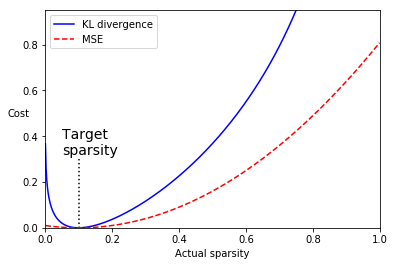

In [17]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mse, "r--", label="MSE")
plt.legend(loc="upper left")
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])

In [18]:
tf.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 1000  # sparse codings
n_outputs = n_inputs

In [19]:
def kl_divergence(p, q):
    # Kullback Leibler divergence
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2

X = tf.placeholder(tf.float32, shape=[None, n_inputs])            # not shown in the book

hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid) # not shown
outputs = tf.layers.dense(hidden1, n_outputs)                     # not shown

hidden1_mean = tf.reduce_mean(hidden1, axis=0) # batch mean
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean))
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE
loss = reconstruction_loss + sparsity_weight * sparsity_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [20]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 100
batch_size = 1000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss, sparsity_loss, loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", reconstruction_loss_val, "\tSparsity loss:", sparsity_loss_val, "\tTotal loss:", loss_val)
        saver.save(sess, "./my_model_sparse.ckpt")

0 Train MSE: 0.12857868 	Sparsity loss: 0.9007431 	Total loss: 0.30872732
1 Train MSE: 0.05915717 	Sparsity loss: 0.020606644 	Total loss: 0.063278496
2 Train MSE: 0.052970145 	Sparsity loss: 0.099999465 	Total loss: 0.07297004
3 Train MSE: 0.047685746 	Sparsity loss: 0.086408064 	Total loss: 0.06496736
4 Train MSE: 0.044119976 	Sparsity loss: 0.02324904 	Total loss: 0.048769783
5 Train MSE: 0.041580226 	Sparsity loss: 0.030357292 	Total loss: 0.047651686
6 Train MSE: 0.039849598 	Sparsity loss: 0.2921525 	Total loss: 0.0982801
7 Train MSE: 0.036784574 	Sparsity loss: 0.03169429 	Total loss: 0.04312343
88% Train MSE: 0.031953104 	Sparsity loss: 0.043875203 	Total loss: 0.040728144
98% Train MSE: 0.030700264 	Sparsity loss: 0.5303583 	Total loss: 0.13677193
10% Train MSE: 0.026560636 	Sparsity loss: 0.017582482 	Total loss: 0.030077133
11% Train MSE: 0.025349848 	Sparsity loss: 0.035947546 	Total loss: 0.032539356
12 Train MSE: 0.023516806 	Sparsity loss: 0.06403364 	Total loss: 0.03632

INFO:tensorflow:Restoring parameters from ./my_model_sparse.ckpt


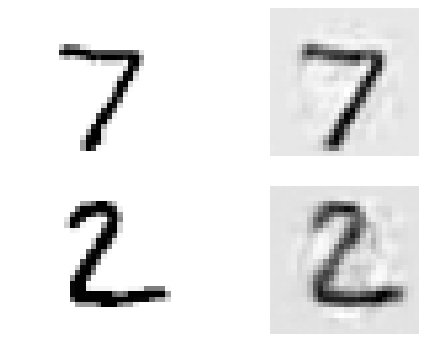

In [22]:
show_reconstructed_digits(X, outputs, "./my_model_sparse.ckpt")

#### Note that the coding layer **must output values from 0 to 1**, which is why we use the sigmoid activation function:

In [23]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid)

To speed up training, you can normalize the inputs between 0 and 1, and use the cross entropy instead of the MSE for the cost function:
```python 
logits = tf.layers.dense(hidden1, n_outputs)
outputs = tf.nn.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_mean(xentropy)
```

## Variational AutoEncoder
<br> <br> The structure of Variational AutoEncoder
<img src="./images/vae_struc.jpg" alt="Drawing" style="width: 400px;"/>

According to the paper [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114) by Diederik P Kingma, Max Welling, (Prior Distribution == Multivariate Gaussian) after applying the **Reparameterize Trick**, the update equation should be <img src="./images/update_equ.jpg" alt="Drawing" style="width: 600px;"/>


<img src="./images/vae_update.jpg" alt="Drawing" style="width: 600px;"/>

In [28]:
tf.reset_default_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()

my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_sigma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_sigma), dtype=tf.float32)
hidden3 = hidden3_mean + hidden3_sigma * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)

update parameters

In [29]:
eps = 1e-10 # smoothing term to avoid computing log(0) which is NaN
latent_loss = 0.5 * tf.reduce_sum(
    tf.square(hidden3_sigma) + tf.square(hidden3_mean)
    - 1 - tf.log(eps + tf.square(hidden3_sigma)))

In [30]:
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [31]:
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)
        saver.save(sess, "./my_model_variational.ckpt")

0 Train total loss: 30892.982 	Reconstruction loss: 25192.078 	Latent loss: 5700.904
1 Train total loss: 26479.498 	Reconstruction loss: 22248.385 	Latent loss: 4231.114
2 Train total loss: 30246.613 	Reconstruction loss: 24441.742 	Latent loss: 5804.8716
39% Train total loss: 29246.807 	Reconstruction loss: 22198.572 	Latent loss: 7048.235
4 Train total loss: 23564.979 	Reconstruction loss: 19657.018 	Latent loss: 3907.961
5 Train total loss: 24407.871 	Reconstruction loss: 20368.953 	Latent loss: 4038.919
6 Train total loss: 20460.445 	Reconstruction loss: 17419.924 	Latent loss: 3040.5215
7 Train total loss: 18463.729 	Reconstruction loss: 15500.557 	Latent loss: 2963.1724
89% Train total loss: 17336.041 	Reconstruction loss: 14456.609 	Latent loss: 2879.431
9 Train total loss: 16678.086 	Reconstruction loss: 13551.635 	Latent loss: 3126.4502
10 Train total loss: 16924.59 	Reconstruction loss: 13807.882 	Latent loss: 3116.7075
11% Train total loss: 16049.297 	Reconstruction loss: 13

In [32]:
tf.reset_default_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()
my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_gamma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_gamma), dtype=tf.float32)
hidden3 = hidden3_mean + tf.exp(0.5 * hidden3_gamma) * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)
latent_loss = 0.5 * tf.reduce_sum(
    tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

### Generate digits
VAE can easily generate NEW images after we got the optimal mu and var


In [34]:
n_digits = 60
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # not shown in the book
            sys.stdout.flush()                                          # not shown
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch}) # not shown
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)  # not shown
        saver.save(sess, "./my_model_variational.ckpt")  # not shown
    
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

0 Train total loss: 18309.676 	Reconstruction loss: 14652.379 	Latent loss: 3657.2974
1 Train total loss: 17665.941 	Reconstruction loss: 13812.877 	Latent loss: 3853.064
29% Train total loss: 15996.771 	Reconstruction loss: 12306.021 	Latent loss: 3690.7505
39% Train total loss: 16582.992 	Reconstruction loss: 12833.282 	Latent loss: 3749.7104
49% Train total loss: 16079.465 	Reconstruction loss: 12288.262 	Latent loss: 3791.203
59% Train total loss: 16266.664 	Reconstruction loss: 12427.944 	Latent loss: 3838.7195
69% Train total loss: 15541.54 	Reconstruction loss: 11795.1455 	Latent loss: 3746.3948
7 Train total loss: 15832.046 	Reconstruction loss: 12077.366 	Latent loss: 3754.6797
8 Train total loss: 15307.751 	Reconstruction loss: 11666.671 	Latent loss: 3641.08
9 Train total loss: 15874.557 	Reconstruction loss: 12106.566 	Latent loss: 3767.9905
10 Train total loss: 15287.209 	Reconstruction loss: 11538.771 	Latent loss: 3748.4377
11 Train total loss: 15596.767 	Reconstruction 

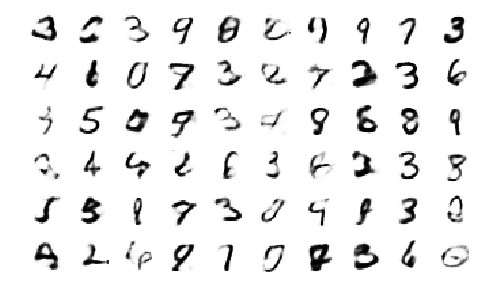

In [35]:
plt.figure(figsize=(8,50)) # not shown in the book
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])

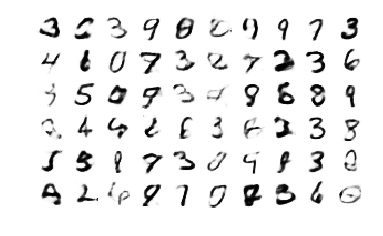

In [37]:
n_rows = 6
n_cols = 10
plot_multiple_images(outputs_val.reshape(-1, 28, 28), n_rows, n_cols)

plt.show()

In [38]:

latent_loss = 0.5 * tf.reduce_sum(
    tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)

## Encode & Decode

In [39]:
# Encode:
n_digits = 3
X_test, y_test = mnist.test.next_batch(batch_size)
codings = hidden3

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    codings_val = codings.eval(feed_dict={X: X_test})

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


In [40]:
# Decode:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    outputs_val = outputs.eval(feed_dict={codings: codings_val})

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


Plot the reconstructions:

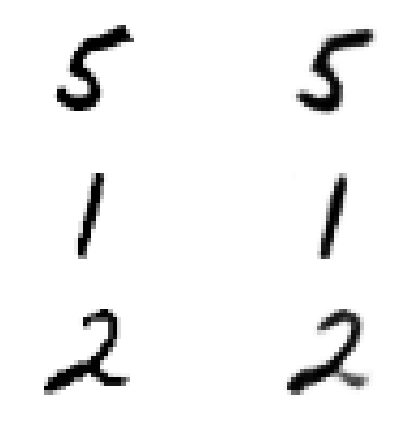

In [41]:
fig = plt.figure(figsize=(8, 2.5 * n_digits))
for iteration in range(n_digits):
    plt.subplot(n_digits, 2, 1 + 2 * iteration)
    plot_image(X_test[iteration])
    plt.subplot(n_digits, 2, 2 + 2 * iteration)
    plot_image(outputs_val[iteration])

### Interpolate digits

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


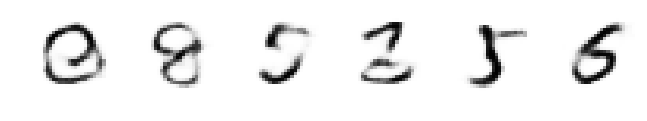

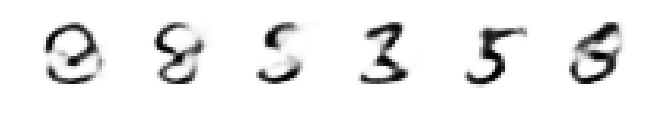

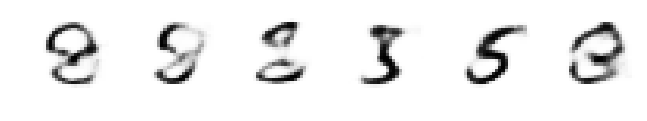

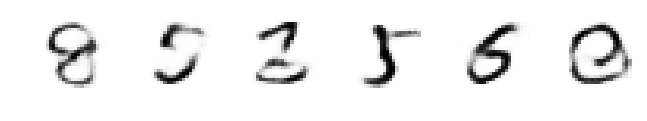

In [42]:
n_iterations = 3
n_digits = 6
codings_rnd = np.random.normal(size=[n_digits, n_hidden3])

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    target_codings = np.roll(codings_rnd, -1, axis=0)
    for iteration in range(n_iterations + 1):
        codings_interpolate = codings_rnd + (target_codings - codings_rnd) * iteration / n_iterations
        outputs_val = outputs.eval(feed_dict={codings: codings_interpolate})
        plt.figure(figsize=(11, 1.5*n_iterations))
        for digit_index in range(n_digits):
            plt.subplot(1, n_digits, digit_index + 1)
            plot_image(outputs_val[digit_index])
        plt.show()